In [1]:
import pickle
import random
import torch
from torch.utils import data
from torchvision import datasets, transforms,models
import numpy as np
import torch.nn as nn
from torch.autograd import Function, Variable
from __future__ import division
from torch.utils import model_zoo
import torch.nn.functional as F
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from scipy.misc import imread, imsave, imresize
import glob
import random
from PIL import Image
torch.multiprocessing.set_sharing_strategy('file_system')
import copy
import warnings
warnings.filterwarnings('ignore')
from tensorboardX import SummaryWriter
from skimage import exposure, img_as_float
import time

## Dataloader

In [3]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    for target in os.listdir(dir):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue
        for root, _, fnames in sorted(os.walk(d)):
            for fname in fnames:
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images

#制作嵌入背景的数据集
class ViewpointDataset(data.Dataset):
    def __init__(self, root, background_path,transform = None):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root,class_to_idx)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))
        self.root = root
        self.imgs = imgs
        self.classes = classes
        #todo
        self.img_width = 227
        self.img_height = 227
        self.img_depth = 3
        self.img_suffix = '.png'
        self.transform = transform
        self.background_path = background_path
        
    def __getitem__(self, idx):
        if self.background_path!=None:
            img_path, label = self.imgs[idx]
            img = imread(img_path)
            img = img[:,:,:3]
            #r = img[:,:,0]
            #img[:,:,0]=img[:,:,2]
            #img[:,:,2]=r
            #preprocess
            img = imresize(img, size=(self.img_height, self.img_width))                      
            #add background
            bg_img_list= glob.glob(os.path.join(self.background_path, '*.bmp'))
            bg_img = imread(random.choice(bg_img_list))
            bg_img = imresize(bg_img, size=(300,300))
            random_seed_region = np.asarray(np.shape(bg_img)[:2]) - np.asarray([self.img_height, self.img_width])
            random_crop_y, random_crop_x = (np.random.random((1,2)) * random_seed_region)[0]

            random_crop_y = np.uint16(random_crop_y)
            random_crop_x = np.uint16(random_crop_x)
            bg_img = bg_img[random_crop_y:random_crop_y+self.img_height, random_crop_x:random_crop_x+self.img_width]
            #split the forground and background of the source images by color (0,0,0)
            mask = np.float32(np.less_equal(img,2))
            img = np.multiply(bg_img , mask) + np.multiply(img, (1-mask)) 
            #img = np.swapaxes(img,2,0)
            #调整亮度
            image = img_as_float(img/255.0)
            #print 'image',image
            r = random.randint(5,20) * 0.1
            img = exposure.adjust_gamma(image, r)   #调暗
            img = img * 255.0
            
            img = np.uint8(img)
            img = Image.fromarray(img)
            if self.transform is not None:
                img = self.transform(img)
            #img = np.swapaxes(img,2,0)

        return img, label
    
    def __len__(self):
        return len(self.imgs)

In [4]:
# For datasets data_loader
def get_dataloader(case, batch_size,category=None):
    print('[INFO] Loading datasets: {}'.format(case))
    datas = {
        'synthetic': '../dataset/'+category+'/synthetic/',
        'real': '../dataset/'+category+'/real3/',
        'adaptation': '../dataset/'+category+'/adaptation3/'
    }
    means = {
        'imagenet': [0.485, 0.456, 0.406]
    }
    stds = {
        'imagenet': [0.229, 0.224, 0.225],
    }

    img_size = (227,227)

    transform = [
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(means['imagenet'], stds['imagenet']),
    ]

    data_loader = data.DataLoader(
        dataset=datasets.ImageFolder(
            datas[case],
            transform=transforms.Compose(transform)
        ),
        num_workers=4,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return data_loader

def get_bg_dataloader(case, batch_size,category=None):
    print('[INFO] Loading datasets: {}'.format(case))
    datas = {
        'synthetic': '../dataset/'+category+'/synthetic/', 
        'background': '../background/'
    }
    means = {
        'imagenet': [0.485, 0.456, 0.406],
    }
    stds = {
        'imagenet': [0.229, 0.224, 0.225],
    }

    img_size = (227,227)

    transform = [
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(means['imagenet'], stds['imagenet']),
    ]
    data_loader=data.DataLoader(
        ViewpointDataset(datas[case],background_path=datas['background'],transform = transforms.Compose(transform)),
        num_workers=4,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )

    return data_loader

def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    #inp = inp.numpy()
    inp = np.uint8(inp)
    plt.imshow(inp)

## Net + Coral loss

In [5]:
CUDA = True if torch.cuda.is_available() else False
#CUDA =False
'''
MODELS
'''

class DoubleStream(nn.Module):
    def __init__(self, num_classes=1000,adap_layer = 512):
        super(DoubleStream, self).__init__()
        #self.sharedNet = AlexNet()
        self.sharedNet = VGGnet()
        self.source_fc = nn.Linear(4096, adap_layer)
        self.target_fc = nn.Linear(4096, adap_layer)
        self.classifier = nn.Linear(adap_layer, num_classes)
        # initialize according to CORAL paper experiment
        self.source_fc.weight.data.normal_(0, 0.005)
        self.target_fc.weight.data.normal_(0, 0.005)

    def forward(self, source, target):
        source = self.sharedNet(source)
        source = self.source_fc(source)
        classifier = self.classifier(source)
        
        target = self.sharedNet(target)
        target = self.source_fc(target)
        target_out  = self.classifier(target)
        return source, target, classifier, target_out


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

class VGGnet(nn.Module):   
    def __init__(self):
        super(VGGnet, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        classifier = vgg16.classifier
        bottleneck = list(classifier.children())[:-3]
        self.bottleneck = nn.Sequential(*bottleneck)
        self.final_fc = nn.Linear(4096,4096)
        
    def forward(self, inputs):
        x1 = self.features(inputs)
        x1 = x1.view(x1.size(0), -1) 
        btn = self.bottleneck(x1)
        return  self.final_fc(F.dropout(F.relu(btn)))

In [6]:
#mmd
def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0))
    m = X.size(0)

    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)


def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2

In [7]:
def train(model, optimizer, epoch, _lambda, _count):
    model.train()
    
    result = []
    acc = []
    source, target = list(enumerate(source_loader,0)), list(enumerate(target_loader,0))
    #train_steps = min(len(source), len(target))
    #train_steps = int(min(len(source), len(target)) / 2)
    train_steps = len(source)
    print len(source)
    print len(target)
    
    for batch_idx in range(train_steps):
        model.train()
        _, (source_data, source_label) = source[batch_idx]
        idx = batch_idx
        if batch_idx >= len(target):
            idx = batch_idx % len(target)
        _, (target_data, _) = target[idx]

        if CUDA:
            source_data = source_data.cuda()
            source_label = source_label.cuda()
            target_data = target_data.cuda()

        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)

        optimizer.zero_grad()
        out1, out2, classifier, _ = model(source_data, target_data)

        classification_loss = torch.nn.functional.cross_entropy(classifier, source_label)
        sigma_list=[1,2,4,8,16]
        #print(out1.data, out2.data)
        if out1.size(0)==out2.size(0):
            mmd2_D = mix_rbf_mmd2(out1,out2, sigma_list)
            mmd2_D = F.relu(mmd2_D)
            mmd_loss=mmd2_D
        else:
            mmd_loss=Variable(torch.Tensor([0.0]).cuda())
        if _lambda == 0:
            sum_loss = classification_loss
        else:
            sum_loss = _lambda*mmd_loss + classification_loss
        sum_loss.backward()
        if _count <= 1000:
            writer.add_scalar('data/Loss',mmd_loss + classification_loss, _count)
            writer.add_scalar('data/MMD_loss',mmd_loss, _count)
            writer.add_scalar('data/total_loss',sum_loss, _count)
        optimizer.step()
        result.append({
            'epoch': epoch,
            'step': batch_idx,
            'total_steps': train_steps,
            'lambda': _lambda,
            'mmd_loss': mmd_loss.data[0],
            'classification_loss': classification_loss.data[0],
            'total_loss': sum_loss.data[0]
        })

        if _count% 50 == 0 and _count <= 1000:
            test_target = test(model, test_loader, e, mode='target')
            print test_target['accuracy']
            writer.add_scalar('data/Test_Accuracy',test_target['accuracy'],_count)
            
        _count += 2

    return result,acc,_count



def test(model, dataset_loader, e, mode='source'):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataset_loader:
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data, volatile=True), Variable(target)
        _, _, out1, out2 = model(data, data)

        out = out1 if mode == 'source' else out2

        # sum up batch loss
        test_loss += torch.nn.functional.cross_entropy(out, target, size_average=False).data[0]

        # get the index of the max log-probability
        #pred = out.data.max(1, keepdim=True)[1]
        pred = torch.topk(out.data,2)[1].cpu().numpy()
        gt = target.data.cpu().numpy()
        for i in range(len(pred)):
            if gt[i] == pred[i][0]:
                correct += 1

    test_loss /= len(dataset_loader.dataset)

    return {
        'epoch': e,
        'average_loss': test_loss,
        'correct': correct,
        'total': len(dataset_loader.dataset),
        'accuracy': 100. * correct / len(dataset_loader.dataset)
    }



# load AlexNet pre-trained model
def load_pretrained(model):
    url = 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'
    pretrained_dict = model_zoo.load_url(url)
    model_dict = model.state_dict()

    # filter out unmatch dict and delete last fc bias, weight
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # del pretrained_dict['classifier.6.bias']
    # del pretrained_dict['classifier.6.weight']

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)


## Train

In [9]:
init_lr = 1e-3
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
BATCH_SIZE = [32,32]
EPOCHS = 2

CATEGORY='wp5'
Adaptation = True
#Adaptation =False
#Background=True
Background=False

if Background:
    source_loader = get_bg_dataloader(case='synthetic', batch_size=BATCH_SIZE[0], category = CATEGORY)
else:
    source_loader = get_dataloader(case='synthetic', batch_size=BATCH_SIZE[0], category = CATEGORY)
target_loader = get_dataloader(case='adaptation', batch_size=BATCH_SIZE[1],category = CATEGORY)
test_loader = get_dataloader(case='real', batch_size=BATCH_SIZE[1],category = CATEGORY)

[INFO] Loading datasets: synthetic
[INFO] Loading datasets: adaptation
[INFO] Loading datasets: real


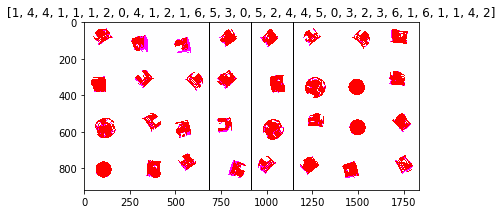

In [10]:
# Get a batch of training data
inputs, classes = next(iter(source_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)
plt.title([x for x in classes])
plt.show()

In [11]:
if __name__ == '__main__':
    since = time.time()
    lam = [0.0,1.0]
    na_acc = []
    a_acc = []
    lam_acc = []
    for i in range(2):
        if i%1 == 0:
            lam_acc = []
        model = DoubleStream(7,4096)
        writer = SummaryWriter()
        if CUDA:
            model = model.cuda()

        #load_pretrained(model.sharedNet)

        _count = 0
        final_acc = []
        for e in range(0, EPOCHS):
            LEARNING_RATE = init_lr * (0.1**(e // 7))
            optimizer = torch.optim.SGD([
                    {'params': model.sharedNet.parameters()},
                    {'params': model.source_fc.parameters(), 'lr': 10*LEARNING_RATE},
                    {'params': model.target_fc.parameters(), 'lr': 10*LEARNING_RATE}
                ], lr=LEARNING_RATE, momentum=MOMENTUM)

            if Adaptation:
                #_lambda = ((e+1)/3) * (5 / EPOCHS)
                ind = int(i/1)
                _lambda = lam[ind]
            else:
                _lambda = 0.0
            res, acc, _count = train(model, optimizer, e+1, _lambda, _count)
            final_acc = final_acc + acc
        print 'ave = ', np.mean(final_acc)
        inde = int(i/1)
        print 'lam = ', lam[inde]
        lam_acc = lam_acc + final_acc
        print 'lam_acc = ', np.mean(lam_acc)
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
        model_name='./model/model'+'_' + CATEGORY + '_' +str(i)+'_adap.pth'
        torch.save(model,model_name)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))

269
4
11.8120805369
65.7718120805
69.6644295302
75.5704697987
73.9597315436
73.1543624161
73.5570469799
73.6912751678
73.0201342282
73.1543624161
72.6174496644
269
4
73.5570469799
72.6174496644
72.4832214765
72.7516778523
73.0201342282
73.288590604
73.288590604
73.4228187919
73.5570469799
73.5570469799
ave =  nan
lam =  0.0
lam_acc =  nan
Training complete in 10m 13s
269
4
17.5838926174
62.0134228188
63.8926174497
69.3959731544
70.6040268456
57.5838926174
74.6308724832
75.9731543624
79.4630872483
81.2080536913
81.610738255
269
4
82.2818791946
83.6241610738
83.4899328859
84.5637583893
84.1610738255
84.8322147651
85.9060402685
85.2348993289
84.966442953
85.6375838926
ave =  nan
lam =  1.0
lam_acc =  nan
Training complete in 24m 6s
Training complete in 24m 12s
